# Projet optimisation : algorithme SDCA

Plan que je propose : 

On va se concentrer sur l'algorithme SVM avec régularisation LASSO. Etant donné que nous sommes exceptionnellement un groupe constitué de trois personnes, nous vous proposons le sujet 1 enrichi avec le sujet 3. Concrètement, nous allons implémenter 4 méthodes d'optimisations, puis les comparer sur la base de données ... (à choisir) :
- Batch Proximal Gradient Descent (primal)
- SDCA (avec eventuellement quelques optimisations présentées dans l'article)
- SVRG
- SAGA

Nous allons d'abord implémenter la version la plus classique de l'algorithme, avant de mettre en oeuvre les variantes et améliorations proposées dans http://www.jmlr.org/papers/volume14/shalev-shwartz13a/shalev-shwartz13a.pdf

In [1]:
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


On commence par définir notre jeu de données de test, ainsi que les fonctions de coût (primal et dual) qui permettront de monitorer l'avancée de l'algorithme

In [2]:
np.random.seed(0)

def binarize(x):
    return np.sign(x)

n_samples, n_features = 5000, 40
X = np.random.randn(n_samples, n_features)
w = np.random.randn(n_features)
b = binarize(X.dot(w) + np.random.randn(n_samples))
step_size = 1.0 / (3 * np.max((X * X).sum(1)))      #ici on travaille toujours avec un step_size constant


def P(theta, lam):
    cost = 1-np.multiply(b,X.dot(theta))
    cost[cost <= 0] = 0
    return np.mean(cost) + (lam/2)*np.linalg.norm(theta)**2

def D(alpha, lam):
    cost = np.multiply(b,X.dot(theta))
    cost[cost > 0] = np.nan
    cost[cost < -1] = np.nan
    return cost                    

## SCDA classique

In [3]:
def SDCA(T, lam):
    alpha = np.zeros(n_samples)
    w = (1/(lam*n_samples))*np.dot(X.T,alpha)
    
    grad_history = np.empty(shape=[T/100])
    cost_history = np.empty(shape=[T/100])
    
    for t in range(0,T):
        # .. pick random sample ..
        idx = np.random.randint(0, n_samples)
        
        # on calcule les constantes A et B (utiles pour la résolution du delta alpha i)
        A = (1/(lam*n_samples)) * np.linalg.norm(X[idx])**2
        B = X[idx].T.dot(w)    
        
        y_i = b[idx]
        delta_alpha_i_tilde = (y_i-B)/A        
        delta_alpha_i = y_i * np.clip(y_i*(delta_alpha_i_tilde + alpha[idx]), a_min=0, a_max=1) - alpha[idx]
        
        alpha[idx] = alpha[idx] + delta_alpha_i
    
        w = (1/(lam*n_samples))*np.dot(X.T,alpha)
        
        if t % 100 == 0: 
            grad_history[t/100] = delta_alpha_i
            cost_history[t/100] = P(w, lam)
        
    return w, grad_history, cost_history
        

In [4]:
theta, grad_history, cost_history = SDCA(1000,step_size)

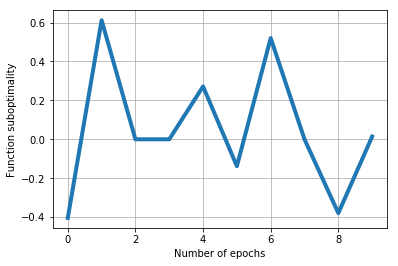

In [5]:
plt.plot(grad_history, lw=4)
plt.grid()
#plt.yscale('log')
plt.ylabel('Function suboptimality')
plt.xlabel('Number of epochs')
plt.show()

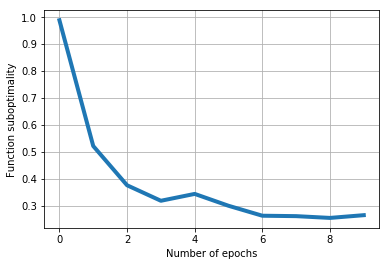

In [6]:
plt.plot(cost_history, lw=4)
plt.grid()
#plt.yscale('log')
plt.ylabel('Function suboptimality')
plt.xlabel('Number of epochs')
plt.show()

## SCDA avec SGD initilisation

In [7]:
...

SyntaxError: invalid syntax (<ipython-input-7-ed20d984b757>, line 1)